<a href="https://colab.research.google.com/github/BimanTamoLabs/AudioMnist/blob/main/AudioMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import time
import math
import shutil

import cv2
import librosa
import librosa.display
import IPython.display as display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm_notebook as tqdm
# from tqdm import notebook.tqdm as tqdm

import glob
import random
import seaborn as sns
from pathlib import Path
sns.set_style("whitegrid")

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
# Reserved
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 153 kB 49.3 MB/s 
     |████████████████████████████████| 181 kB 46.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [ ]:
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist'
if os.path.exists('./audio-MNIST'):
    shutil.rmtree('./audio-MNIST')

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashansugathadasa
Your Kaggle Key: ··········


100%|██████████| 948M/948M [00:08<00:00, 119MB/s]


In [ ]:
path = '/content/audio-mnist/data'
annot_list = []
for folder in os.listdir(path):
    if os.path.isdir(path + '/' + folder):
        for file in os.listdir(path + '/' + folder):  
            file_path = path + '/' + folder + '/' + file
            label = file[0]
            annot_list.append((file_path, label))
# Although the os.listdir does not follow any apparent order, I will shuffle it just to be safe.

import random
random.shuffle(annot_list)

# Split in train and test

train_size = int(0.75*len(annot_list))
train_list = annot_list[:train_size]
test_list = annot_list[train_size:]

# Finally created the annnotations file

import csv

with open(os.path.join(path, 'train_audioMNIST.csv'), mode='w') as csv_file:  
    csv_writer = csv.writer(csv_file)
    for item in train_list:
        csv_writer.writerow([item[0], item[1]])  

with open(os.path.join(path, 'test_audioMNIT.csv'), mode='w') as csv_file:  
    csv_writer = csv.writer(csv_file)
    for item in test_list:
        csv_writer.writerow([item[0], item[1]]) 

In [ ]:
data_dir = '/content/audio-mnist'
os.listdir(data_dir)

['data']

In [ ]:
train_df = pd.read_csv('/content/audio-mnist/data/train_audioMNIST.csv')
test_df = pd.read_csv('/content/audio-mnist/data/test_audioMNIT.csv')
path_audio = '/content/audio-mnist/data'

In [ ]:
train_df.columns = ['audio_path','label']
test_df.columns = ['audio_path','label']

In [ ]:
train_df.head()

,audio_path,label
0,/content/audio-mnist/data/11/3_11_12.wav,3
1,/content/audio-mnist/data/04/6_04_24.wav,6
2,/content/audio-mnist/data/38/5_38_2.wav,5
3,/content/audio-mnist/data/45/8_45_22.wav,8
4,/content/audio-mnist/data/27/2_27_15.wav,2


In [ ]:
unique_audios = train_df.groupby(['label']).apply(lambda sub_df:sub_df.sample()).reset_index(drop = True)
unique_audios.head()

,audio_path,label
0,/content/audio-mnist/data/37/0_37_30.wav,0
1,/content/audio-mnist/data/39/1_39_39.wav,1
2,/content/audio-mnist/data/41/2_41_48.wav,2
3,/content/audio-mnist/data/19/3_19_27.wav,3
4,/content/audio-mnist/data/20/4_20_38.wav,4


In [ ]:
unique_audios['label'].values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
unique_audios['label'].count()

10

In [ ]:
#helper functions
def load_audio(file):
    y, sr = librosa.load(file)
    return y, sr

def listen_example(file):
    return display.Audio(file)

def wav_plot(file, ax):
    y, sr = librosa.load(file)
    return librosa.display.waveplot(y, ax=ax)

def mel_spectrogram_plot(file, ax):
    y, sr = librosa.load(file)
    S = librosa.feature.melspectrogram(y, sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), ax=ax)

def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, 
                          n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav, sr = librosa.load(file_path, sr=sr)
    if wav.shape[0]<5*sr:
        wav = np.pad(wav, int(np.ceil((5*sr-wav.shape[0])/2)), mode='reflect')
    else:
        wav = wav[:5*sr]
    spec = librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                                          hop_length=hop_length, n_mels=n_mels, 
                                          fmin=fmin, fmax=fmax)
    spec_db = librosa.power_to_db(spec, top_db=top_db)
    return spec_db

In [ ]:
# load a wave data
def load_wave_data(file_path):
    #file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x, fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft, n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in plots
def listen_example(file): 
    return display.Audio(file)

def wav_plot(file, ax):
    y, sr = librosa.load(file)
    return librosa.display.waveplot(y, ax=ax)

# display wave in heatmap
def show_melsp(melsp, fs, ax=None):
    if ax is not None:
        librosa.display.specshow(melsp, sr=fs, ax=ax)
    else:
        librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

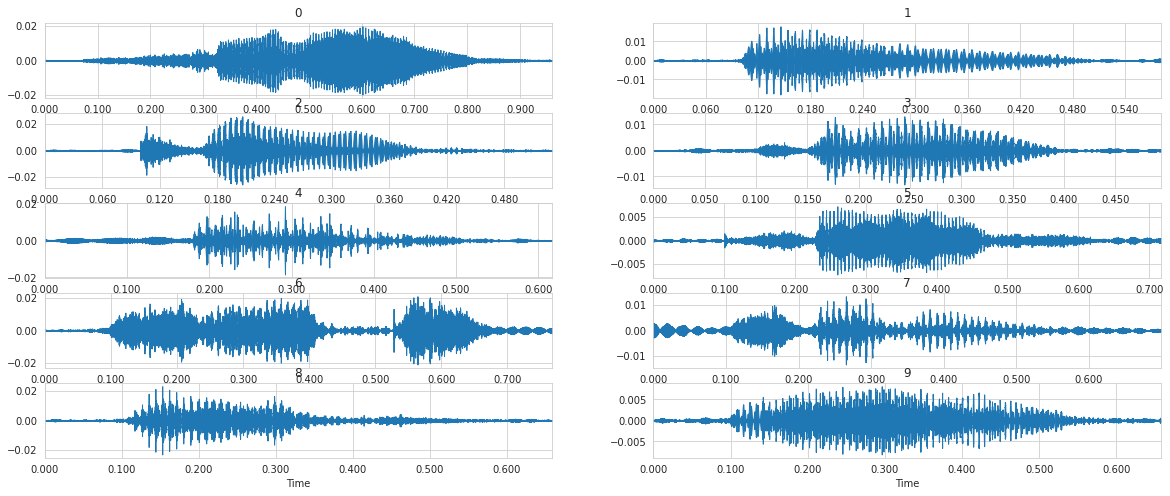

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20, 8), constrained_layout=False)
axs = np.reshape(axs, -1)

for (index, row), ax in zip(unique_audios.iterrows(), axs):

    ax.set_title(row.values[1])
    wav_plot(row.values[0], ax=ax)

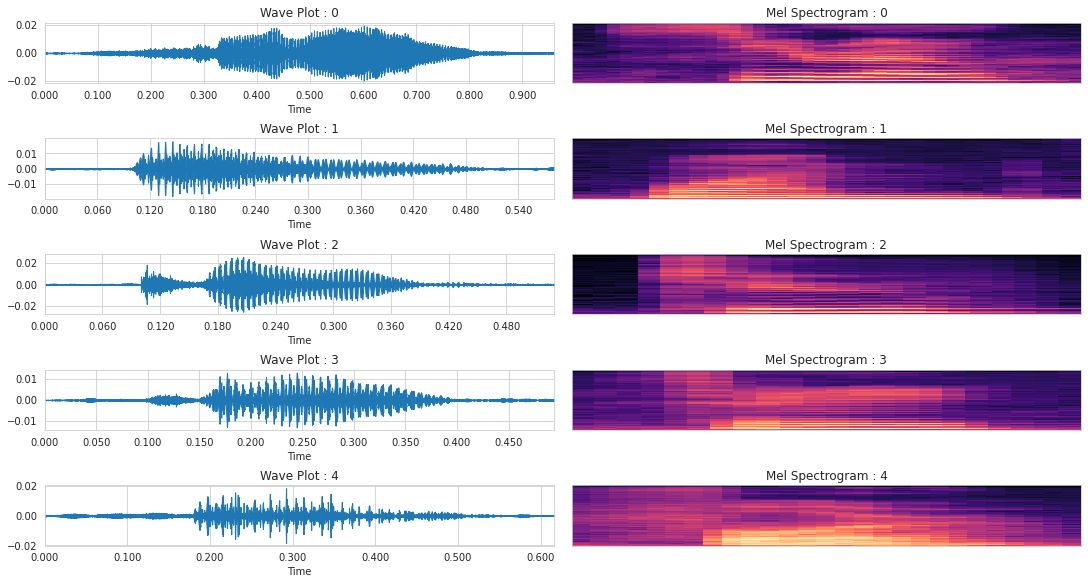

In [ ]:
unique_audios_5 = unique_audios.head()
fig, axs = plt.subplots(5, 2, figsize=(15, 8), constrained_layout=True)

for (index,row),ax in zip(unique_audios_5.iterrows(), axs):

    ax[0].set_title(f"Wave Plot : {row.values[1]}")
    wav_plot(row.values[0], ax=ax[0])

    ax[1].set_title(f"Mel Spectrogram : {row.values[1]}")
    mel_spectrogram_plot(row.values[0], ax=ax[1])

In [ ]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [ ]:
class AudioDatasetSpectrogram(Dataset):
    def __init__(self, annotations_file, ToSpectrogram, ToDB):
        self.annotations = pd.read_csv(annotations_file, header=None, 
                               names=['Path', 'Label'], delimiter=',')
        self.ToSpectrogram = ToSpectrogram
        self.ToDB = ToDB
        
    def __len__(self):
        return(len(self.annotations))
    
    def __getitem__(self, index):
        audio_padded = torch.zeros((1,48000))
        audio = torchaudio.load(self.annotations.iloc[index, 0])
        audio_padded[0,:len(audio[0][0])] = audio[0][0]
        label = self.annotations.iloc[index, 1]
        spectrogram = self.ToSpectrogram(audio_padded)
        spectrogram = self.ToDB(spectrogram)
        return(spectrogram, label)

In [ ]:
class AudioMNIST(Dataset):
    def __init__(self, data, label, data_aug=False, _type='train'):
        self.label = label
        self.data_aug = data_aug
        self.data = data
        self.audio_clip = 32000
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        label = self.label[idx]
        x, fs = load_wave_data(self.data[idx])
        x = librosa.util.fix_length(x, size=self.audio_clip, mode='edge')
        # print('...', x.shape)
        
        # augumentations in wave domain.
        if self.data_aug:
            r = np.random.rand()
            if r < 0.3:
                x = add_white_noise(x)

            r = np.random.rand()
            if r < 0.3:
                x = shift_sound(x, rate=1+np.random.rand())

            r = np.random.rand()
            if r < 0.3:
                x = stretch_sound(x, rate=0.8+np.random.rand()*0.4)
        
        # convert to melsp
        melsp = calculate_melsp(x)
        
        # normalize
        mean = np.mean(melsp)
        std = np.std(melsp)
        
        melsp -= mean
        melsp /= std
        
        melsp = np.asarray([melsp, melsp, melsp])
        return melsp, label

In [ ]:
# get training dataset and target dataset
x = list(train_df.loc[:,"audio_path"])
y = list(train_df.loc[:, "label"])

x_train, x_test, y_train, y_test = \
model_selection.train_test_split(x, y, test_size=0.25, 
                                 stratify=y, random_state=42)
len(x_train), len(x_test)

(16874, 5625)

In [ ]:
batch_size = 128
watermark = "resnet34"
model_name = watermark
CONTINUE = False

In [ ]:
ToSpectrogram = torchaudio.transforms.MelSpectrogram()
ToDB = torchaudio.transforms.AmplitudeToDB()
train_dataset = AudioDatasetSpectrogram('/content/audio-mnist/data/train_audioMNIST.csv', ToSpectrogram, ToDB)
test_dataset = AudioDatasetSpectrogram('/content/audio-mnist/data/test_audioMNIT.csv', ToSpectrogram, ToDB)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 128, 241])


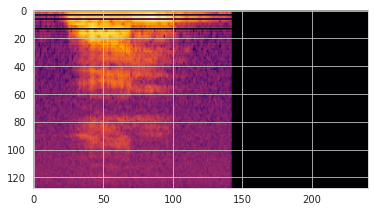

In [ ]:
spectrogram, label = next(iter(train_dataset))
print(spectrogram.shape)
plt.imshow(spectrogram[0], cmap='inferno')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 251)


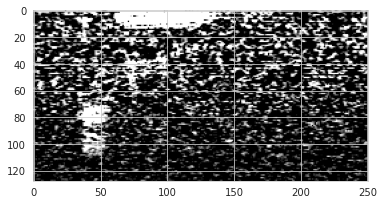

In [ ]:
traindataset = AudioMNIST(x_train, y_train, data_aug=True)
testdataset = AudioMNIST(x_test, y_test, data_aug=False)

train_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=0)
mel, label = traindataset[7]
print(mel.shape)
plt.imshow(mel.transpose([1, 2, 0]))

In [ ]:
mel, label = next(iter(traindataset))
print(mel.shape)

(3, 128, 251)


In [ ]:
class AudioClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images.float())  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float()) # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class CNN(AudioClassificationBase):
    def __init__(self, input_shape, batch_size=16, num_cats=10):
        super(CNN, self).__init__()
        self.ConvNet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=7, stride=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7410, num_cats)
        )

        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        logits = self.ConvNet(x)
        return(logits)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
!pip install pretrainedmodels

# backbone
import pretrainedmodels
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, 
                                                  pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8707d10548a642d658e4b0eeb484b74c49869d86f6cf51fcb1e808696f23dca6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
class CustomModel(AudioClassificationBase):
    def __init__(self, input_shape, batch_size=16, num_cats=10):
        super(CustomModel, self).__init__()
        self.features = basemodel
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        self.fc = nn.Conv2d(num_ch, num_cats, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x).squeeze(2).squeeze(2)
        return x

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(project, config, model, train_loader, val_loader, logging=False):

    epochs, lr, opt_func = config['epochs'], config['lr'], config['optimizer']

    history = []
    optimizer = opt_func(model.parameters(), lr)
    example_ct = 0

    n_steps_per_epoch = math.ceil(len(train_loader)/config['batch_size'])

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for step, batch in enumerate(tqdm(train_loader, leave=False)):
            images, labels = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            example_ct += len(images)
            if logging:
                metrics = {"train/train_loss": loss, 
                        "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                        "train/example_ct": example_ct}
            
            if step + 1 < n_steps_per_epoch and logging:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        if logging:
            # 🐝 Log train and validation metrics to wandb
            val_metrics = {"val/val_loss": result['val_loss'], 
                            "val/val_accuracy": result['val_acc']}
            wandb.log({**metrics, **val_metrics})

    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(project, config, model, train_loader, val_loader, logging=False):
    torch.cuda.empty_cache()

    epochs, max_lr, weight_decay, grad_clip, opt_func = config['epochs'], \
    config['max_lr'], config['weight_decay'], config['grad_clip'], config['optimizer']
    # wandb.init(project=project, config=config)

    history = []

    example_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader)/config['batch_size'])

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for step, batch in enumerate(tqdm(train_loader, leave=False)):
            images, labels = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
            example_ct += len(images)
            if logging:
                metrics = {"train/train_loss": loss, 
                           "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                           "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch and logging:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        if logging:
            # 🐝 Log train and validation metrics to wandb
            val_metrics = {"val/val_loss": result['val_loss'], 
                            "val/val_accuracy": result['val_acc']}
            wandb.log({**metrics, **val_metrics})

    return history

In [ ]:
num_epochs = 15
opt_func = optim.Adam
lr = 1e-4

device = get_default_device()
device

device(type='cuda')

In [ ]:
# WandB configs and project name
project="Audio_MNIST"
config={
        "model_name": model_name, 
        "input_shape": (3, 38, 19), 
        "num_cats": 10, 
        "epochs": 2,
        "batch_size": 64,
        "lr": 1e-4,
        "device": get_default_device(),
        "optimizer": optim.Adam
        }

In [ ]:
logging_wandb = False

In [ ]:
if logging_wandb:
    wandb.init(project=project, config=config)

In [ ]:
model = CustomModel(input_shape=config['input_shape'], 
                    batch_size=config['batch_size'],
                    num_cats=config['num_cats']).to(config['device'])

In [ ]:
model = CNN(input_shape=config['input_shape'], 
            batch_size=config['batch_size'], 
            num_cats=config['num_cats']).to(config['device'])

In [ ]:
train_dl = DeviceDataLoader(train_loader, config['device'])
valid_dl = DeviceDataLoader(test_loader, config['device'])

to_device(model, config['device'])

CustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 8min 31s, sys: 3min 42s, total: 12min 13s
Wall time: 6min 26s


In [ ]:
# Training phase
history = fit(project, config, model, train_dl, valid_dl, logging_wandb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3014, val_loss: 0.0080, val_acc: 0.9986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0433, val_loss: 0.0086, val_acc: 0.9975


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');



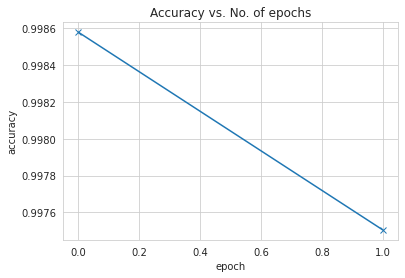

In [ ]:
plot_accuracies(history)

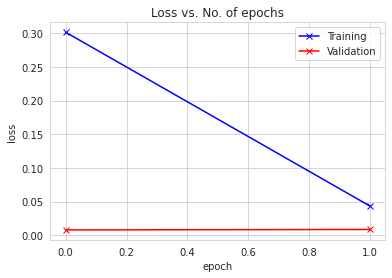

In [ ]:
plot_losses(history)

In [ ]:
config_finetune={
    "model_name": model_name, 
    "input_shape": (3, 38, 19), 
    "num_cats": 10, 
    "epochs": 1,
    "batch_size": 64,
    "max_lr": 1e-4,
    "device": get_default_device(),
    "optimizer": optim.Adam, 
    "grad_clip": 0.1, 
    "weight_decay": 1e-4
    }

In [ ]:
%%time
history += fit_one_cycle(project, config_finetune, model, train_dl, 
                         valid_dl, logging_wandb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0326, val_loss: 0.0023, val_acc: 0.9996
CPU times: user 37min 41s, sys: 18min 27s, total: 56min 8s
Wall time: 29min 10s


In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
def get_predictions_and_labels_df(model, val_dataloader):

    actual_array = []
    predicted_array = []

    # looping
    for batch in val_dataloader:
        images, labels = batch
        model.eval()
        out = model(images.float())
        _, preds = torch.max(out, dim=1)
        actual_array.extend(labels.detach().cpu().tolist())
        predicted_array.extend(preds.detach().cpu().tolist())
    
    df = pd.DataFrame(list(zip(actual_array, predicted_array)), 
                      columns=['Actual_Label', 'Predicted_Label'])
    
    return df


df = get_predictions_and_labels_df(model, valid_dl)
df

,Actual_Label,Predicted_Label
0,5,5
1,5,5
2,7,7
3,4,4
4,3,3
...,...,...
5620,2,2
5621,7,7
5622,9,9
5623,2,2


In [ ]:
class_labels = [str(item) for item in range(config['num_cats'])]

In [ ]:
if logging_wandb:
    # Log confusion matrix
    # the key "conf_mat" is the id of the plot--do not change
    # this if you want subsequent runs to show up on the same plot
    y_true_arrays = df['Actual_Label'].tolist()
    y_pred_arrays = df['Predicted_Label'].tolist()

    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                            preds=y_pred_arrays, y_true=y_true_arrays, 
                            class_names=class_labels)})

In [ ]:
# Get category based DF
df['Actual_Label'] = df['Actual_Label'].map(lambda x: str(x))
df['Predicted_Label'] = df['Predicted_Label'].map(lambda x: str(x))
df.head()

,Actual_Label,Predicted_Label
0,5,5
1,5,5
2,7,7
3,4,4
4,3,3


In [ ]:
y_true = df['Actual_Label'].tolist()
y_pred = df['Predicted_Label'].tolist()
cmtx = pd.DataFrame(confusion_matrix(y_true, y_pred, 
                                     labels=class_labels), 
                    index=class_labels, columns=class_labels
                    )

Text(159.0, 0.5, 'Actual Labels')

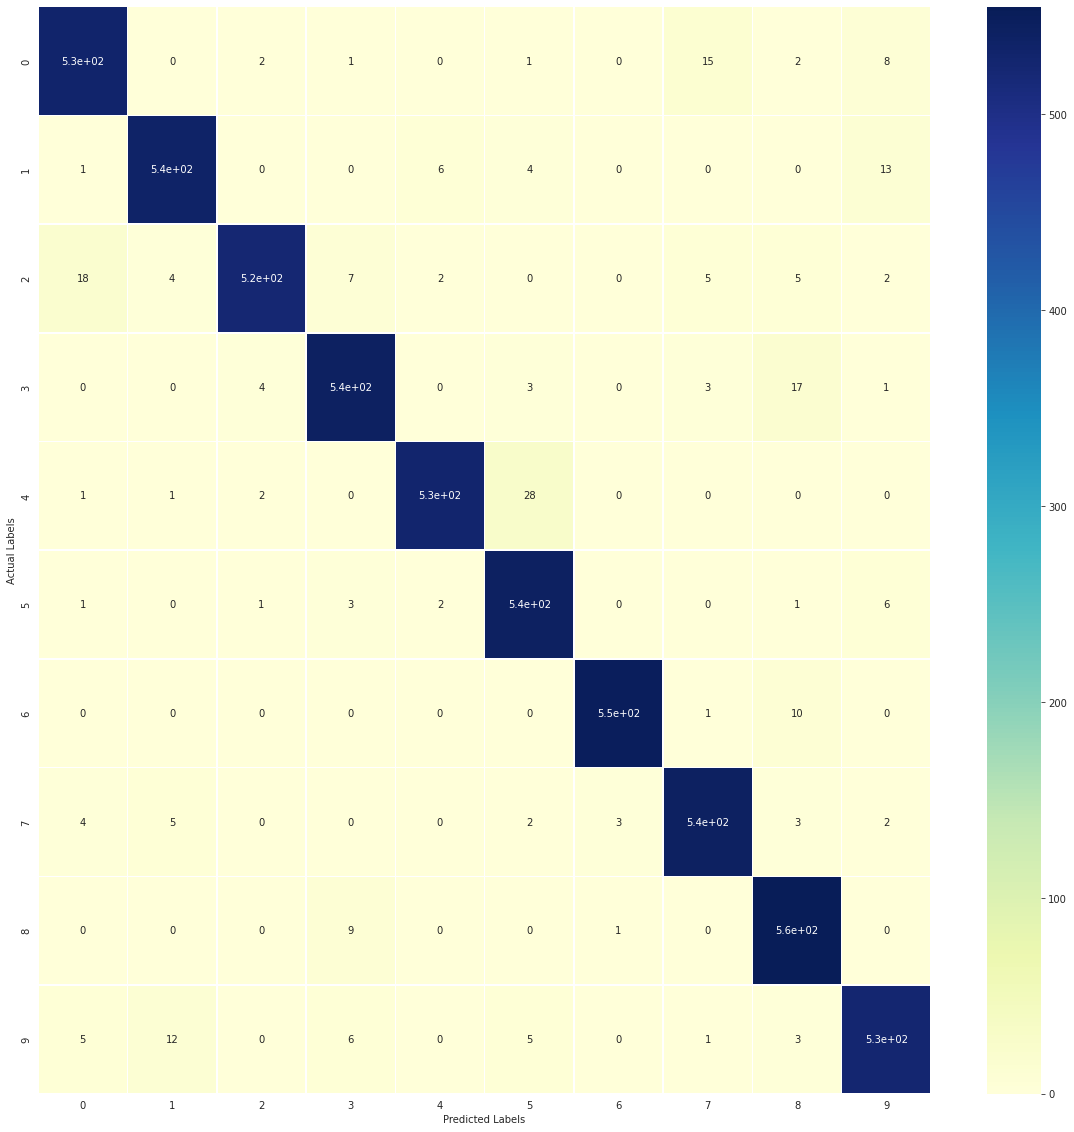

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))         # Sample figsize in inches

sns.heatmap(cmtx, annot=True, cmap='YlGnBu', linewidths=.5, ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

In [ ]:
if logging_wandb:
    # 🐝 Close your wandb run 
    wandb.finish()

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█
train/example_ct,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▅█
train/train_loss,████████████████▃▄▂▁▁▁
val/val_accuracy,▁█
val/val_loss,█▁
train/epoch,45.0
train/example_ct,33748
train/train_loss,0.46755
val/val_accuracy,0.957
val/val_loss,0.1688
